## Dataset

In [ ]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

In [ ]:
df = pd.read_json("https://raw.githubusercontent.com/sahil280114/codealpaca/master/data/code_alpaca_20k.json")

# create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set

total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)
df = df.head(n=1000)

In [ ]:
df.head(10)

,instruction,input,output,split
0,Create an array of length 5 which contains all...,,"arr = [2, 4, 6, 8, 10]",0
1,Formulate an equation to calculate the height ...,,Height of triangle = opposite side length * si...,0
2,Write a replace method for a string class whic...,"string = ""Hello World!""\nreplace_with = ""Greet...","def replace(self, replace_with):\n new_stri...",0
3,Create an array of length 15 containing number...,,"arr = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33...",0
4,Write a function to find the number of distinc...,"matrix = [[1, 0, 0],\n [1, 0, 1],\n ...",def find_num_distinct_states(matrix):\n sta...,0
5,Create a nested loop to print every combinatio...,,for i in range(10):\n for j in range(10):\n...,0
6,Write a function to find the maximum differenc...,"arr = [5, 3, 17, 11, 9]",def max_difference(arr):\n max_diff = 0\n ...,0
7,Write a function to generate the nth Fibonacci...,< noinput >,def fib(n):\n if n == 0:\n return 0\...,0
8,Write a class to represent a 2D point with x a...,,"class Point:\n def __init__(self, x, y):\n ...",0
9,Write code that removes spaces from a given st...,"string = "" A B C D ""","def remove_spaces(string): \n return """".joi...",0


In [ ]:
num_self_sufficient = (df['input'] == '').sum()
num_need_context = df.shape[0] - num_self_sufficient

print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"{round(num_self_sufficient/df.shape[0] * 100, 2)}% of examples that are self-sufficient")
print(f"{round(num_need_context/df.shape[0] * 100, 2)}% of examples that are need additional context")

Total number of examples in the dataset: 1000
47.2% of examples that are self-sufficient
52.8% of examples that are need additional context


Average number of tokens in the instruction column: 23
Average number of tokens in the input column: 8
Average number of tokens in the output column: 65



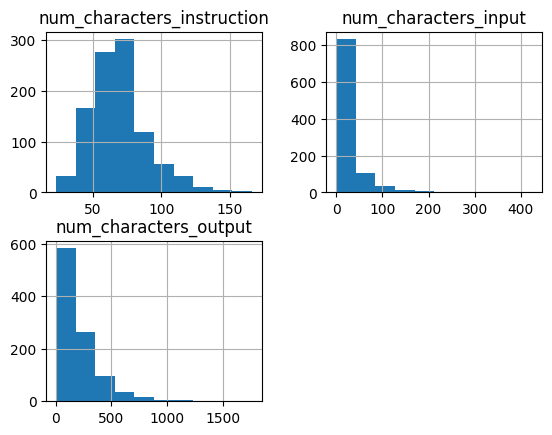

In [ ]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

In [ ]:
df[df['split'] == 0][['instruction', 'input',	'output']].shape

(898, 3)

In [ ]:
json_result = df[df['split'] == 0][['instruction', 'input',	'output']].to_json(orient='records')

In [ ]:
with open('training_data.json', 'w') as file:
    file.write(json_result)

In [ ]:
!ls

config.json  data.json	multi-lora-fine-tune  sample_data  training_data.json


## Fine-tune

In [ ]:
!git clone https://github.com/TUDB-Labs/multi-lora-fine-tune.git

Cloning into 'multi-lora-fine-tune'...
remote: Enumerating objects: 1034, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 1034 (delta 323), reused 331 (delta 289), pack-reused 581
Receiving objects: 100% (1034/1034), 6.33 MiB | 1.34 MiB/s, done.
Resolving deltas: 100% (573/573), done.


In [ ]:
!pip install -r multi-lora-fine-tune/requirements.txt

In [ ]:
config_string = """
{
    "cutoff_len": 256,
    "group_by_length": false,
    "expand_right": true,
    "pad_token_id": -1,
    "save_step": 2000,
    "early_stop_test_step": 2000,
    "train_lora_candidate_num": 4,
    "train_lora_simultaneously_num": 2,
    "train_strategy": "optim",
    "lora": [
        {
            "name": "lora_0",
            "output": "lora_0",
            "optim": "adamw",
            "lr": 3e-4,
            "batch_size": 16,
            "micro_batch_size": 4,
            "test_batch_size": 64,
            "num_epochs": 30,
            "r": 8,
            "alpha": 16,
            "dropout": 0.05,
            "target_modules": {
                "q_proj": true,
                "k_proj": false,
                "v_proj": true,
                "o_proj": false,
                "w1_proj": false,
                "w2_proj": false,
                "w3_proj": false
            },
            "data": "training_data.json",
            "prompt": "multi-lora-fine-tune/template/template_demo.json"
        },
        {
            "name": "lora_1",
            "output": "lora_1",
            "optim": "adamw",
            "lr": 3e-4,
            "batch_size": 16,
            "micro_batch_size": 4,
            "test_batch_size": 64,
            "num_epochs": 1,
            "r": 8,
            "alpha": 16,
            "dropout": 0.05,
            "target_modules": {
                "q_proj": true,
                "k_proj": false,
                "v_proj": true,
                "o_proj": false,
                "w1_proj": false,
                "w2_proj": false,
                "w3_proj": false
            },
            "data": "multi-lora-fine-tune/data/data_demo.json",
            "prompt": "multi-lora-fine-tune/template/template_demo.json"
        }
    ]
}
"""

with open("./config.json", "w") as f:
    f.write(config_string)


In [ ]:
!python multi-lora-fine-tune/mlora.py \
  --base_model openlm-research/open_llama_3b \
  --config config.json

## Inference

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive

 aclImdb						   Notability
'Colab Notebooks'					  'Notability (1)'
 data							  'Notability (2)'
 data.xlsx						   stop_words.txt
'History courses info'					   transcript.pdf
'Instagram Likes Classification Project Summary.gslides'  'Yufei Wang - CV_V6.pdf'
 lora_0


In [ ]:
!pip install peft

In [ ]:
from peft import PeftModel
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer
import torch

In [ ]:
base_model = 'openlm-research/open_llama_3b'
lora_weights = '/content/gdrive/MyDrive/lora_0'

tokenizer = LlamaTokenizer.from_pretrained(base_model)
model = LlamaForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="cuda:0",
)
model = PeftModel.from_pretrained(
    model,
    lora_weights,
    torch_dtype=torch.float16,
)

tokenizer.model:   0%|          | 0.00/534k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
df[df['split'] == 1][['instruction', 'input',	'output']]

,instruction,input,output
34,"Create a JSX code that renders a ""Hello, World...",,"import React from ""react"";\n\nfunction App() {..."
58,Generate a random number between 0 and 1 (incl...,,Math.random(); // a random number between 0 an...
96,Create a quick-sort algorithm in Python.,,"def quick_sort(arr):\n """"""Sort a list of nu..."
99,Write a function that takes in a list of numbe...,"list = [8, 2, 14, 25]","def find_greatest(list):\n """"""Print out the..."
109,Create a function to calculate the maximum of ...,,"def max_of_two(x, y):\n if x > y:\n ..."
120,Write a Java program to generate random numbers,,import java.util.Random; \n \npublic class Ge...
146,Write an SQL query to select the number of emp...,,"SELECT department, COUNT(employee_ID)\nFROM em..."
153,Write an SQL query to calculate the difference...,,SELECT SUM(CASE WHEN gender = 'female' THEN sa...
170,Write an algorithm to find the largest element...,"[8, 11, 12, 5, 3]",// Algorithm to find the largest element in an...
203,Write a code to find the maximum in a given li...,"mylist = [1,2,3,4,5]","""""""\nWrite a code to find the maximum in a giv..."


In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [ ]:
device = "cuda:0"
prompt = "Create a function to calculate the maximum of two numbers."
encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
  outputs = model.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )

  full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
  answer = full_text.replace(prompt, '').strip()
  print(answer)